In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime 
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
#from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')


plt.style.use('seaborn')

# suppress scientific notation
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 40)

# set working directory
os.chdir('C:/Users/hmenon/Documents/Project_misc/H_analysis')

In [2]:
#list_data.dtypes

In [3]:
# Reading in Listing data
list_data = pd.read_csv('redfin_2021-01-23-10-03-54.csv', header = 0)

# MLS # is the unique identifier for each property
list_data['MLS#']= list_data['MLS#'].astype(str)


In [4]:
#list_data.head(10)

In [5]:
# Reading in refernce data for each neighborhood
# This data includes compiled data on distance to downtown areas and if itfalls within preferred commute time during peak hours and normal time
neigh_data = pd.read_csv('Neighborhood_ref.csv', header = 0)
neigh_data.rename(columns = {'Neighborhood':'LOCATION'}, inplace = True) 
neigh_data.head(10)

,LOCATION,dist_seattle,dist_bellevue,normal_State_flag,peak_time_flag
0,Magnolia,15,28,No,Yes
1,Queen Anne,15,27,No,Yes
2,Wallingford,11,19,Yes,Yes
3,Fremont,10,20,Yes,Yes
4,Phinney Ridge,12,21,No,Yes
5,Ravenna,10,18,Yes,Yes
6,Ballard,19,29,No,Yes
7,Greenwood,16,22,No,Yes
8,West Seattle,25,36,No,No
9,Northgate,19,20,Yes,Yes


In [6]:
# Joining the two datasets
list_data_final = pd.merge(list_data,  
                      neigh_data,  
                      on ='LOCATION',  
                      how ='left')

# Adding new transformed features for ranking such as Yard space, age of the house
list_data_final["Yard_size_est"] = list_data_final["LOT SIZE"]- list_data_final["SQUARE FEET"]
list_data_final["Year_since_built"] = 2021 - list_data_final["YEAR BUILT"]
list_data_final["Lat_diff"] = 47.60 - list_data_final["LATITUDE"]
list_data_final["Long_diff"] = 122.33 - list_data_final["LONGITUDE"].abs()
list_data_final["Lat_Long_diff"] = list_data_final["Lat_diff"].abs() + list_data_final["Long_diff"].abs()
list_data_final.head(5)

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE,dist_seattle,dist_bellevue,normal_State_flag,peak_time_flag,Yard_size_est,Year_since_built,Lat_diff,Long_diff,Lat_Long_diff
0,MLS Listing,nan,Single Family Residential,17016 NE 19th St,Bellevue,WA,98008,989000,4,2.25,Bellevue,2130,7172.00,1964.00,1.00,464,nan,Active,nan,nan,http://www.redfin.com/WA/Bellevue/17016-NE-19t...,NWMLS,1719500,N,Y,47.63,-122.11,14.00,8.00,Yes,Yes,5042.00,57.00,-0.03,0.22,0.24
1,MLS Listing,nan,Single Family Residential,6742 3rd Ave NW,Seattle,WA,98117,999950,3,1.75,Phinney Ridge,2305,5000.00,1906.00,2.00,434,nan,Active,nan,nan,http://www.redfin.com/WA/Seattle/6742-3rd-Ave-...,NWMLS,1719754,N,Y,47.68,-122.36,12.00,21.00,No,Yes,2695.00,115.00,-0.08,-0.03,0.11
2,MLS Listing,nan,Single Family Residential,2305 W Raye St,Seattle,WA,98199,1100000,4,2.75,Magnolia,2020,1582.00,2018.00,2.00,545,nan,Active,nan,nan,http://www.redfin.com/WA/Seattle/2305-W-Raye-S...,NWMLS,1714044,N,Y,47.64,-122.39,15.00,28.00,No,Yes,-438.00,3.00,-0.04,-0.06,0.10
3,MLS Listing,nan,Single Family Residential,319 N 80th St,Seattle,WA,98103,799999,3,1.75,Greenwood,2120,3030.00,1916.00,2.00,377,nan,Active,nan,nan,http://www.redfin.com/WA/Seattle/319-N-80th-St...,NWMLS,1717867,N,Y,47.69,-122.35,16.00,22.00,No,Yes,910.00,105.00,-0.09,-0.02,0.11
4,MLS Listing,nan,Single Family Residential,312 NW 81st St,Seattle,WA,98117,819000,3,1.75,Greenwood,1700,4800.00,1915.00,3.00,482,nan,Active,nan,nan,http://www.redfin.com/WA/Seattle/312-NW-81st-S...,NWMLS,1714621,N,Y,47.69,-122.36,16.00,22.00,No,Yes,3100.00,106.00,-0.09,-0.03,0.12


In [7]:
# Setting up all the criteria flags based on preferences across different attributes

list_data_final["SQFT_Match"] = list_data_final["SQUARE FEET"].apply(lambda x: 1 if x >= 1700 else 0)
list_data_final["Bed_Match"] = list_data_final["BEDS"].apply(lambda x: 1 if x >= 3 else 0)
list_data_final["Bath_Match"] = list_data_final["BATHS"].apply(lambda x: 1 if x >= 1.75 else 0)
list_data_final["Built_Year_Match"] = list_data_final["YEAR BUILT"].apply(lambda x: 1 if x >= 1970 else 0)
list_data_final["Price_Match"] = list_data_final["PRICE"].apply(lambda x: 1 if x <= 975000 else 0)
list_data_final["Dist_Seattle_Match"] = list_data_final["dist_seattle"].apply(lambda x: 1 if x <= 25 else 0)
list_data_final["Dist_Bellevue_Match"] = list_data_final["dist_bellevue"].apply(lambda x: 1 if x <= 30 else 0)
list_data_final["Price_per_sqft_Match"] = list_data_final["$/SQUARE FEET"].apply(lambda x: 1 if x <= 470 else 0)
list_data_final["Property_type_Match"] = list_data_final["PROPERTY TYPE"].apply(lambda x: 1 if x == "Single Family Residential" else 0)
list_data_final["peak_time_match"] = list_data_final["peak_time_flag"].apply(lambda x: 1 if x == "Yes" else 0)
list_data_final["lot_size_match"] = list_data_final["LOT SIZE"].apply(lambda x: 1 if x >=2000 else 0)
list_data_final["days_on_market_match"] = list_data_final["DAYS ON MARKET"].apply(lambda x: 1 if x <= 20 else 0)

In [8]:
# Creating a dataset that includes only single family homes since that is the preference
sngl_fmly_list_data = list_data_final.loc[(list_data_final["PROPERTY TYPE"]=="Single Family Residential") & (list_data_final["SOURCE"]=="NWMLS"),]

# Selecting numeric attributes for the dataset and replacing missing values with the mean of the attribute distribution
sngl_fmly_train_data = sngl_fmly_list_data[['MLS#','SQUARE FEET','LOT SIZE','$/SQUARE FEET','DAYS ON MARKET','dist_seattle','dist_bellevue','Yard_size_est','Year_since_built','PRICE','BEDS','BATHS','Lat_Long_diff']].fillna(sngl_fmly_list_data.mean())
sngl_fmly_train_data['Yard_size_est']= sngl_fmly_train_data['Yard_size_est'].abs()

# Setting the MLS # as the index
sngl_fmly_train_data = sngl_fmly_train_data.set_index('MLS#')
sngl_fmly_train_data.head(5)

,SQUARE FEET,LOT SIZE,$/SQUARE FEET,DAYS ON MARKET,dist_seattle,dist_bellevue,Yard_size_est,Year_since_built,PRICE,BEDS,BATHS,Lat_Long_diff
MLS#,,,,,,,,,,,,
1719500,2130,7172.00,464,1.00,14.00,8.00,5042.00,57.00,989000,4,2.25,0.24
1719754,2305,5000.00,434,2.00,12.00,21.00,2695.00,115.00,999950,3,1.75,0.11
1714044,2020,1582.00,545,2.00,15.00,28.00,438.00,3.00,1100000,4,2.75,0.10
1717867,2120,3030.00,377,2.00,16.00,22.00,910.00,105.00,799999,3,1.75,0.11
1714621,1700,4800.00,482,3.00,16.00,22.00,3100.00,106.00,819000,3,1.75,0.12


In [9]:
# Normalizing values since the ranges vary between features
# Define min max scaler
scaler = MinMaxScaler()
# transform data
scaled_list_data = pd.DataFrame(scaler.fit_transform(sngl_fmly_train_data), index=sngl_fmly_train_data.index, columns=sngl_fmly_train_data.columns)
#scaled_list_data

In [10]:
# Modifying direction on attributes where optimization is through minimization(Lower the better)
# Change the scaled value to 1- x
scaled_list_data["$/SQUARE FEET"] = 1 - scaled_list_data["$/SQUARE FEET"]
scaled_list_data["DAYS ON MARKET"] = 1 - scaled_list_data["DAYS ON MARKET"]
scaled_list_data["dist_seattle"] = 1 - scaled_list_data["dist_seattle"]
scaled_list_data["dist_bellevue"] = 1 - scaled_list_data["dist_bellevue"]
scaled_list_data["Year_since_built"] = 1 - scaled_list_data["Year_since_built"]
scaled_list_data["PRICE"] = 1 - scaled_list_data["PRICE"]
scaled_list_data["Lat_Long_diff"] = 1 - scaled_list_data["Lat_Long_diff"]

In [11]:
# Applying weighted scores 
# Weight per attribute configurable based on preferences 
# Range between 0 and 1 with increasing importance
weights = {'sq_feet':0.6, 'lot_size':0.7,'price_per_sqft':0.8,'days_on_market':0.9,'dist_seattle':0.7,'dist_bellevue':0.5,'yard_size':0.7,'years_since_built':0.8,'price':0.6,'lat_long_diff':0.7}
scaled_list_data["final_weighted_Score"]= (scaled_list_data["SQUARE FEET"]*weights['sq_feet'])+(scaled_list_data["LOT SIZE"]*weights['lot_size'])+(scaled_list_data["$/SQUARE FEET"]*weights['price_per_sqft'])+(scaled_list_data["DAYS ON MARKET"]*weights['days_on_market'])+(scaled_list_data["dist_seattle"]*weights['dist_seattle'])+(scaled_list_data["dist_bellevue"]*weights['dist_bellevue'])+(scaled_list_data["Yard_size_est"]*weights['yard_size'])+(scaled_list_data["Year_since_built"]*weights['years_since_built'])+(scaled_list_data["PRICE"]*weights['price'])+(scaled_list_data["Lat_Long_diff"]*weights['lat_long_diff'])

In [12]:
scaled_list_data = scaled_list_data.sort_values(['final_weighted_Score','SQUARE FEET','dist_seattle'],ascending = [0,0,0])
scaled_list_data.reset_index(level=0, inplace=True)
#scaled_list_data = scaled_list_data.reindex(columns=['MLS#','final_weighted_Score'])
scaled_list = scaled_list_data[['MLS#','final_weighted_Score']]
scaled_list

,MLS#,final_weighted_Score
0,1719789,4.32
1,1719118,4.23
2,1716438,4.22
3,1720199,4.20
4,1685483,4.07
...,...,...
73,1597297,2.88
74,1633181,2.80
75,1710927,2.61
76,1612301,2.43


In [13]:
# Merging the dataset with weighted scores to original listing_data 
Weighted_list_data_final = pd.merge(scaled_list,  
                      list_data_final,  
                      on ='MLS#',  
                      how ='left') 

# Calculating a match percentage for each listing based on 12 criterias set
Weighted_list_data_final['Match_percentage']= (Weighted_list_data_final['SQFT_Match']+Weighted_list_data_final['Bed_Match']+Weighted_list_data_final['Bath_Match']+Weighted_list_data_final['Built_Year_Match']+Weighted_list_data_final['Price_Match']+Weighted_list_data_final['Dist_Seattle_Match']+Weighted_list_data_final['Dist_Bellevue_Match']+Weighted_list_data_final['Price_per_sqft_Match']+Weighted_list_data_final['Property_type_Match']+Weighted_list_data_final['peak_time_match']+Weighted_list_data_final['lot_size_match']+Weighted_list_data_final['days_on_market_match'])/12
# Sorting the dataset by Match percentage and Weighted Scores to rank the listings
Weighted_list_data_final = Weighted_list_data_final.sort_values(['Match_percentage','final_weighted_Score'],ascending = [0,0])
Weighted_list_data_final = Weighted_list_data_final.reindex(columns=["MLS#","Match_percentage","final_weighted_Score","LOCATION","CITY","ADDRESS","SQUARE FEET","LOT SIZE","$/SQUARE FEET","DAYS ON MARKET","dist_seattle","dist_bellevue","YEAR BUILT","PRICE","BEDS","BATHS"])
Weighted_list_data_final = Weighted_list_data_final[["MLS#","Match_percentage","final_weighted_Score","LOCATION","CITY","ADDRESS","SQUARE FEET","LOT SIZE","$/SQUARE FEET","DAYS ON MARKET","dist_seattle","dist_bellevue","YEAR BUILT","PRICE","BEDS","BATHS"]]

In [14]:
# Weighted score distribtuion 
Weighted_list_data_final['final_weighted_Score'].describe()

count   78.00
mean     3.34
std      0.39
min      2.32
25%      3.09
50%      3.27
75%      3.54
max      4.32
Name: final_weighted_Score, dtype: float64

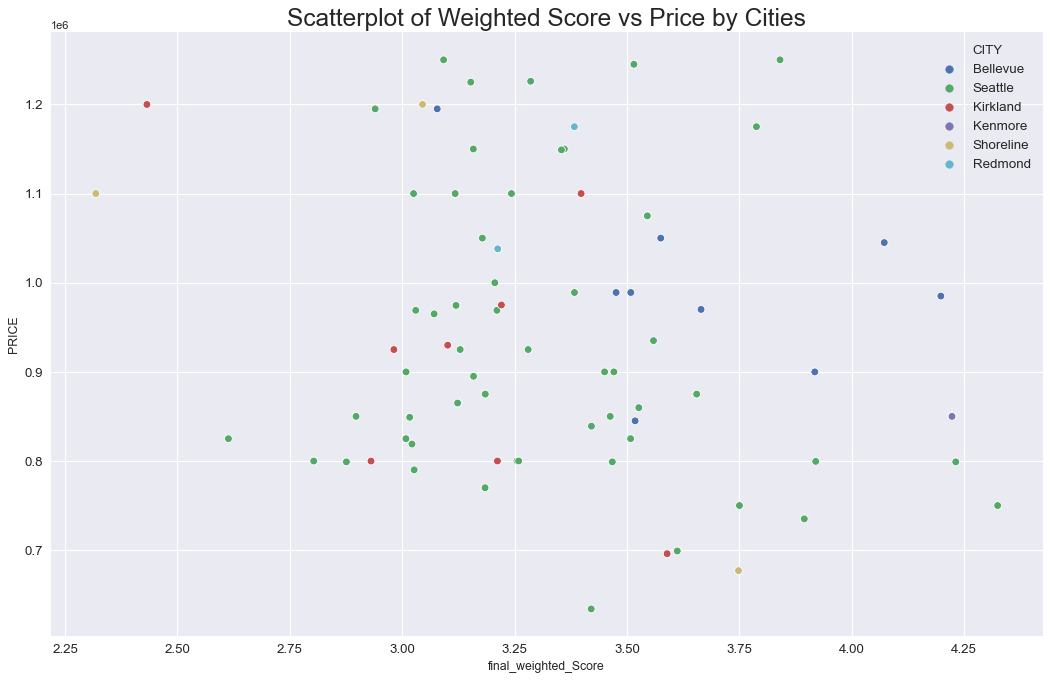

In [15]:
# Scatterplot to obtain a visual of properties with high weighted score with a view on Price and the City they are in
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.scatterplot(data=Weighted_list_data_final, x="final_weighted_Score", y="PRICE", hue="CITY")

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot of Weighted Score vs Price by Cities", fontsize=22)
plt.legend(fontsize=12)    
plt.show()  

In [16]:
# Displaying the top 10 listings ranked by Match percentage and Weighted score
Weighted_list_data_final.head(10)

,MLS#,Match_percentage,final_weighted_Score,LOCATION,CITY,ADDRESS,SQUARE FEET,LOT SIZE,$/SQUARE FEET,DAYS ON MARKET,dist_seattle,dist_bellevue,YEAR BUILT,PRICE,BEDS,BATHS
6,1718913,1.00,3.92,Phantom Lake,Bellevue,16552 SE 19th St,2022,11689.00,445,2.00,14.00,10.00,1974.00,899950,3,2.25
5,1719309,0.92,3.92,Seattle,Seattle,10415 15th Ave NE,1700,5998.00,470,2.00,5.00,15.00,1959.00,799500,4,2.00
7,1718469,0.92,3.92,Bellevue,Bellevue,103 155th Ave NE,2373,8470.00,379,4.00,14.00,8.00,1961.00,899900,4,2.25
8,1719596,0.92,3.89,Crown Hill,Seattle,10514 11th Ave NW,2459,6300.00,299,2.00,15.00,23.00,1956.00,735000,3,2.50
10,1713964,0.92,3.79,Phinney Ridge,Seattle,501 N 72nd St,2873,3000.00,409,7.00,12.00,21.00,2004.00,1175000,3,3.25
13,1717265,0.92,3.66,Lake Hills,Bellevue,16634 SE 8th St,2300,8423.00,422,2.00,14.00,10.00,1957.00,970000,4,2.75
14,1718434,0.92,3.65,Woodland Park,Seattle,4812 Aurora Ave N,2580,2350.00,339,4.00,11.00,19.00,1918.00,875000,4,2.50
16,1719081,0.92,3.59,Kingsgate,Kirkland,12510 NE 140th St,2150,7314.00,324,2.00,21.00,15.00,1975.00,695950,4,2.75
17,1717215,0.92,3.58,Whispering Heights,Bellevue,15525 SE 44th Pl,2490,8800.00,422,2.00,17.00,13.00,1975.00,1050000,3,2.25
18,1719588,0.92,3.56,Wallingford,Seattle,4607 Woodlawn Ave N,2364,2712.00,396,2.00,11.00,19.00,1928.00,935000,3,1.75
